# Clustering

## Introduction

The dataset AAPL includes the information about Apple's stock price for recent half years. In order to make it to be not time sensitive, I add a column called daily return which calculates the difference between open stock price and close stock price in each single day. This dataset also has a column which represents the trading volumn for each day. I am doing clustering for these two variables and to find out the most common situation for Apple's stock holders.

## Theory

K-Means: randomly initialize centroids and assign each data point to the nearest centroid, and then re-locate the centroids, and repeat the process of assigning data points and calculating new means for each centroid, until the centroids do not change significantly after recalculating.

Elbow method: calculate the sum of squared distances of samples to centroids, make a plot and find out the elbow point, where the rate of increase/decrease slow down.

Silhouette: The silhouette ranges from -1 to 1, higher score means better match for the closest centroid, the highest silhouette score represents the optimal choice.

DBSCAN: Density-Based Spatial Clustering of Applications with Noise, it creates clusters based on the density of data points. When using this algorithm, we needs to determine the eps (the radius of a neighborhood around a point) and min_samples (the minimum number of points required to form a dense region). We start with a random point, form cluster for all points within the neighborhood, repeat the process until all points get labeled (core, border, noise)

Hierarchical: There are two forms in hierarchical clustering: agglomerative(bottom-up) and divisive(top-down). In agglomerative, we start by treating each point as a cluster, then merge down the closest pair of clusters, repeat the process until there is only one big cluster left. Divisive starts by a large cluster, and then break this cluster down.

## Method

### Data selection

Select the trading volumn and daily return. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

AAPL = pd.read_csv('AAPL_Cleaned.csv')
AAPL.head()


,Unnamed: 0,timestamp,open,high,low,close,volume,daily_return
0,0,2023-12-05,190.21,194.40,190.1800,193.42,66628398,NaN
1,1,2023-12-04,189.98,190.05,187.4511,189.43,43389519,-2.062868
2,2,2023-12-01,190.33,191.56,189.2300,191.24,45704823,0.955498
3,3,2023-11-30,189.84,190.32,188.1900,189.95,48794366,-0.674545
4,4,2023-11-29,190.90,192.09,188.9700,189.37,43014224,-0.305344


### Feature Selection

In [2]:
AAPL = AAPL.drop('timestamp', axis=1)
AAPL = AAPL.drop('Unnamed: 0', axis=1)
AAPL = AAPL.dropna()
AAPL.head()

,open,high,low,close,volume,daily_return
1,189.98,190.05,187.4511,189.43,43389519,-2.062868
2,190.33,191.56,189.2300,191.24,45704823,0.955498
3,189.84,190.32,188.1900,189.95,48794366,-0.674545
4,190.90,192.09,188.9700,189.37,43014224,-0.305344
5,189.78,191.08,189.4000,190.40,38415419,0.543909


### Hyper-parameter tuning

#### K-Means

In [3]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(AAPL)
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    sse.append(kmeans.inertia_)


/Users/srongmu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/srongmu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/srongmu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/srongmu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will chang

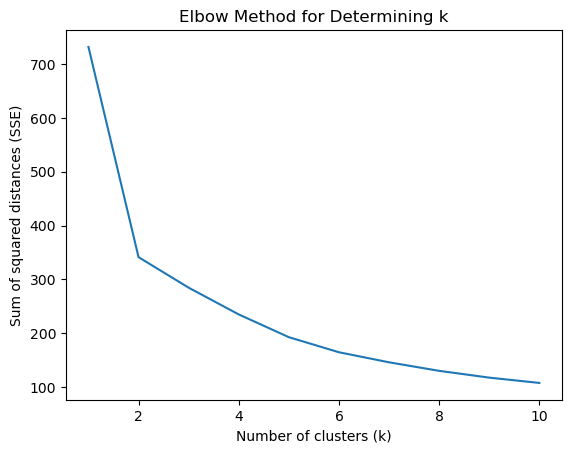

In [4]:
plt.figure()
plt.plot(range(1, 11), sse)
plt.title('Elbow Method for Determining k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances (SSE)')
plt.show()

The optimal number of clusters is 3

#### DBSCAN

In [5]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

In [6]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
AAPL['Cluster'] = dbscan.fit_predict(df_scaled)
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = range(2, 10)

best_silhouette_score = -1
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(df_scaled)

        if len(set(cluster_labels)) > 1 and np.sum(cluster_labels != -1) < len(df_scaled)-1:
            silhouette_avg = silhouette_score(df_scaled, cluster_labels)

            if silhouette_avg > best_silhouette_score:
                best_silhouette_score = silhouette_avg
                best_eps = eps
                best_min_samples = min_samples
print(f"Best silhouette score is {best_silhouette_score} with eps={best_eps} and min_samples={best_min_samples}")


Best silhouette score is 0.25298680124699197 with eps=0.9 and min_samples=8


#### Hierarchical - Agglomerative Clustering

In [7]:
from sklearn.cluster import AgglomerativeClustering

In [8]:
num_clusters = range(2, 10)
silhouette_scores = {}

for n_clusters in num_clusters:
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    cluster_labels = agg_clustering.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores[n_clusters] = silhouette_avg

best_num_clusters = max(silhouette_scores, key=silhouette_scores.get)
print(f'Best number of clusters based on silhouette score: {best_num_clusters}')

best_agg_clustering = AgglomerativeClustering(n_clusters=best_num_clusters, affinity='euclidean', linkage='ward')
best_cluster_labels = best_agg_clustering.fit_predict(df_scaled)


Best number of clusters based on silhouette score: 2


/Users/srongmu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/srongmu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/srongmu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/srongmu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/Users/srongmu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: Fu

### Final Results

K-Means: k=3

DBSCAN: min_samples=3, eps=0.8

Agglomerative: n_clusters=3

/Users/srongmu/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


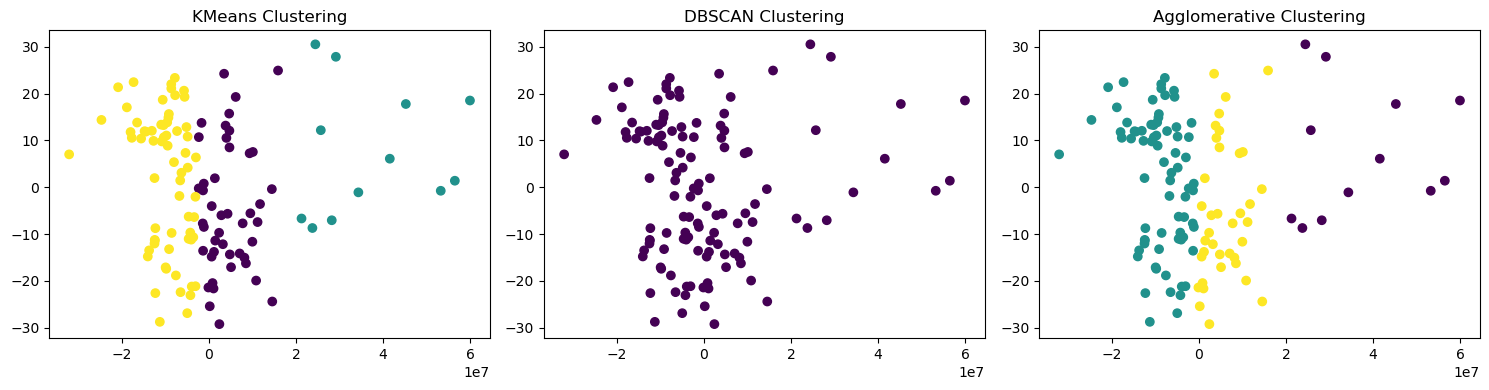

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
AAPL_reduced = pca.fit_transform(AAPL)

kmeans = KMeans(n_clusters=3, random_state=5000).fit(AAPL_reduced)
dbscan = DBSCAN(eps=0.8, min_samples=3).fit(AAPL_reduced)
agglomerative = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(AAPL_reduced)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(AAPL_reduced[:, 0], AAPL_reduced[:, 1], c=kmeans.labels_)
axes[0].set_title('KMeans Clustering')

axes[1].scatter(AAPL_reduced[:, 0], AAPL_reduced[:, 1], c=dbscan.labels_)
axes[1].set_title('DBSCAN Clustering')

axes[2].scatter(AAPL_reduced[:, 0], AAPL_reduced[:, 1], c=agglomerative.labels_)
axes[2].set_title('Agglomerative Clustering')

plt.tight_layout()
plt.show()

### Results and Conclusion

Based on the plot we got from K-Means, DBSCAN, Agglomerative Clustering, the optimal number of clusters should be 3. Both K-Means and Agglomerative assign the datapoint into 3 clusters, DBSCAN does not constrain the number of clusters, but determines based on eps and minimum sample size. 